# Práctica 5

En esta práctica deberás implementar distintos métodos de aprendizaje semi-supervisado.

## Ejercicio obligatorio: Pseudo-labeling (5 puntos)

A continuación se listan una serie de datasets que están disponibles en Kaggle (algunos de los datasets seleccionados han sido recortados para que puedan entrenarse los modelos en un tiempo razonable). Para cada uno de ellos se os proporciona un enlace al dataset para que podáis descargarlo directamente. Elige uno de los siguientes datasets (o uno de tu elección) y realiza los ejercicios detallados a continuación.

- [Blidness dataset](https://www.kaggle.com/c/aptos2019-blindness-detection). Enlace: https://www.dropbox.com/s/cv5dfjagvj8fqk8/blindness.zip?dl=1.
- [Chest xRay dataset](https://www.kaggle.com/nih-chest-xrays/data). Enlace: https://www.dropbox.com/s/q6s4wu7q3yrpwrm/chest_xray.zip?dl=1.
- [Docknet dataset](https://www.kaggle.com/gavinarmstrong/open-sprayer-images). Enlace: https://www.dropbox.com/s/a5pzvpafvgfqvf0/Docknet.zip?dl=1.
- [Tobacco dataset](https://www.kaggle.com/sprytte/tobacco-800-dataset). Enlace: https://www.dropbox.com/s/wy44c0rsv8jogka/tobacco.zip?dl=1.

Comienza descargando el dataset de tu elección.

In [1]:
from fastai.vision.all import *
!wget https://www.dropbox.com/s/q6s4wu7q3yrpwrm/chest_xray.zip?dl=1 -O chest_xray.zip
!unzip chest_xray.zip
path = Path('chest_xray/')
path.ls()

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0449-0001.jpeg  
 

(#2) [Path('chest_xray/train'),Path('chest_xray/test')]

Vamos a simular un entorno semi-supervisado para lo cual tienes que reestructurar tu dataset de manera que en el conjunto de entrenamiento haya únicamente 20 imágenes por clase, y el resto de imágenes las guardarás en una carpeta llamada unlabelled. Al acabar, tu estructura de carpetas debería ser algo similar a lo siguiente:

```.
└── dataset
    ├── test
    │   ├── claseA
    │   └── claseB
    ├── train
    │   ├── claseA
    │   └── claseB
    └── unlabelled
```

In [2]:
import shutil
import os

trainPath = path/'train'
testPath = path/'test'

normal = trainPath/'NORMAL'
pneumonia = trainPath/'PNEUMONIA'
unlabelled = path/'unlabelled'

unlabelled.mkdir(exist_ok=True)

#eliminamos el archivo .DS_Store de la carpeta
os.remove(normal/".DS_Store")
os.remove(trainPath/".DS_Store")

lista = normal.ls()

for i in range(20, len(lista)):
    try:
        shutil.move(lista[i], unlabelled)
    except:
        print(i)

lista = pneumonia.ls()
for i in range(20, len(lista)):
    try:
        shutil.move(lista[i], unlabelled)
    except:
        print(i)

In [3]:
trainPath.ls()

(#2) [Path('chest_xray/train/PNEUMONIA'),Path('chest_xray/train/NORMAL')]

In [4]:
(trainPath/'NORMAL').ls()

(#20) [Path('chest_xray/train/NORMAL/NORMAL2-IM-1154-0001-0001.jpeg'),Path('chest_xray/train/NORMAL/IM-0182-0001.jpeg'),Path('chest_xray/train/NORMAL/NORMAL2-IM-1336-0001.jpeg'),Path('chest_xray/train/NORMAL/IM-0432-0001.jpeg'),Path('chest_xray/train/NORMAL/IM-0546-0001.jpeg'),Path('chest_xray/train/NORMAL/NORMAL2-IM-0862-0001.jpeg'),Path('chest_xray/train/NORMAL/NORMAL2-IM-1116-0001-0002.jpeg'),Path('chest_xray/train/NORMAL/IM-0339-0001.jpeg'),Path('chest_xray/train/NORMAL/NORMAL2-IM-1198-0001.jpeg'),Path('chest_xray/train/NORMAL/NORMAL2-IM-0636-0001.jpeg')...]

Siguiendo los pasos de la práctica 1 entrena un modelo con el dataset que has creado y evalúalo en el conjunto de test. Añade a continuación todas las celdas que necesites.

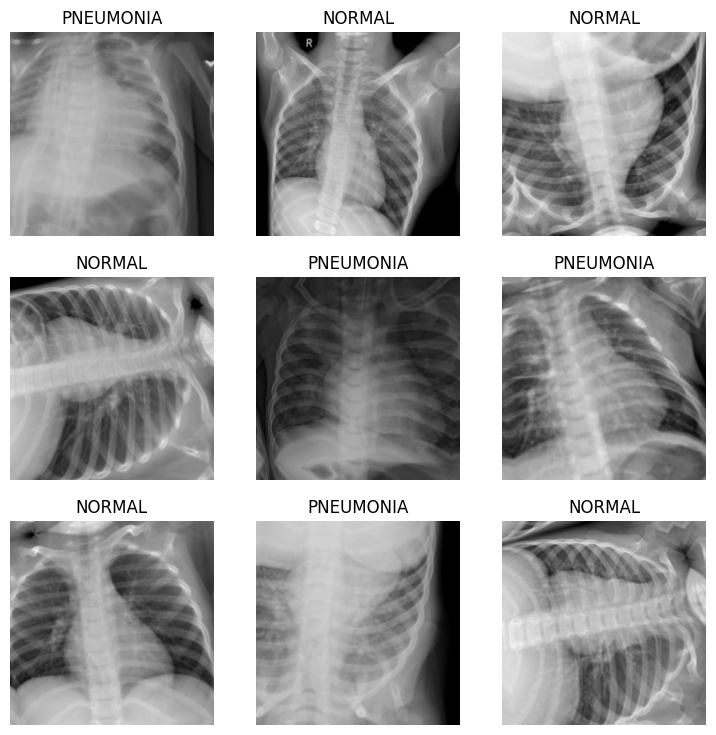

In [5]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.15,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256,flip_vert=True,max_rotate=15),Normalize.from_stats(*imagenet_stats)])
dls = db.dataloaders(trainPath,bs=20) # Mantenemos el batch de 128, como en el ejemplo
dls.show_batch()

In [6]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=10),
    SaveModelCallback(fname='modelResnet34ChestXRay')
]
learn = vision_learner(dls,resnet34,metrics=[accuracy, Precision(), Recall()],cbs=callbacks).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 176MB/s]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(valley=0.001737800776027143)

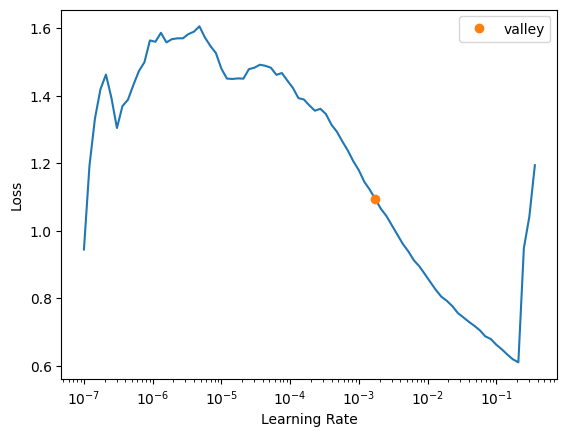

In [7]:
l_r = learn.lr_find()
l_r

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.543050,2.930679,0.333333,0.000000,0.000000,00:00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 2.9306793212890625.


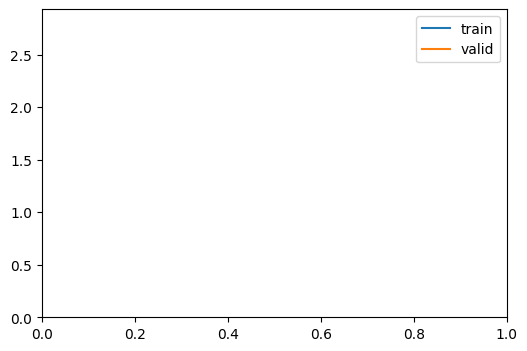

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.850598,2.449394,0.333333,0.000000,0.000000,00:01
1,0.815511,2.472390,0.333333,0.000000,0.000000,00:00
2,0.989202,2.281538,0.333333,0.000000,0.000000,00:00
3,1.092022,2.393568,0.333333,0.000000,0.000000,00:00
4,1.032157,2.143652,0.333333,0.000000,0.000000,00:00
5,1.049369,2.149101,0.333333,0.000000,0.000000,00:00
6,0.983058,2.079411,0.333333,0.000000,0.000000,00:00
7,0.925298,1.919804,0.333333,0.000000,0.000000,00:00
8,0.855462,1.859957,0.333333,0.000000,0.000000,00:00
9,0.787788,1.892030,0.500000,1.000000,0.250000,00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 2.4493939876556396.


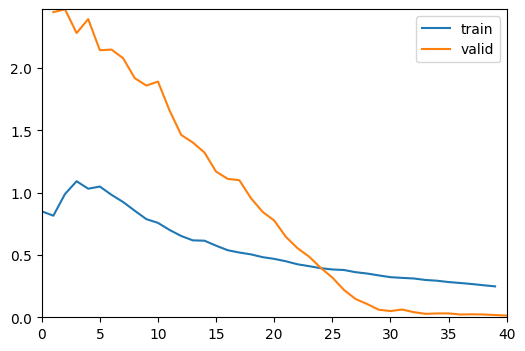

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

Better model found at epoch 2 with valid_loss value: 2.281538486480713.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

Better model found at epoch 4 with valid_loss value: 2.1436522006988525.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

Better model found at epoch 6 with valid_loss value: 2.079411268234253.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 7 with valid_loss value: 1.9198036193847656.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 8 with valid_loss value: 1.8599570989608765.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 10 with valid_loss value: 1.659342885017395.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 11 with valid_loss value: 1.4636545181274414.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 12 with valid_loss value: 1.4025977849960327.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 13 with valid_loss value: 1.3222460746765137.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 14 with valid_loss value: 1.1689143180847168.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 15 with valid_loss value: 1.1111607551574707.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 16 with valid_loss value: 1.1002990007400513.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 17 with valid_loss value: 0.9557762742042542.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 18 with valid_loss value: 0.846321165561676.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 19 with valid_loss value: 0.7763175964355469.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 20 with valid_loss value: 0.6458704471588135.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 21 with valid_loss value: 0.5549842715263367.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 22 with valid_loss value: 0.48676764965057373.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 23 with valid_loss value: 0.396909236907959.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 24 with valid_loss value: 0.3189243972301483.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 25 with valid_loss value: 0.21943019330501556.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 26 with valid_loss value: 0.1464880108833313.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 27 with valid_loss value: 0.10621441155672073.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 28 with valid_loss value: 0.06035997346043587.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 29 with valid_loss value: 0.05011335387825966.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 31 with valid_loss value: 0.041181936860084534.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 32 with valid_loss value: 0.02766021154820919.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 35 with valid_loss value: 0.022290756925940514.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 38 with valid_loss value: 0.01788095384836197.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 39 with valid_loss value: 0.014191997237503529.


In [8]:
# Aumentamos las epocas por lo que tenemos un conjunto tan pequeño
learn.fine_tune(40,base_lr=l_r.valley)

In [9]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=[*aug_transforms(size=128,min_scale=0.75),Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=128)
learn.dls = dlsTest
learn.validate()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 0 with valid_loss value: 0.6442307829856873.


(#4) [2.762861967086792,0.6442307829856873,0.9719101123595506,0.44358974358974357]

Una vez que has entrenado el modelo utilizalo para aplicar la técnica de pseudo-labeling. Para ello deberás utilizar el modelo para obtener la clase de cada una de las imágenes de la carpeta ``unlabelled`` y su nivel de confianza. Crea un nuevo dataset análogo al inicial pero donde aquellas imágenes cuya predicción tenga un nivel de confianza superior a 0.8 se almacenen en la carpeta correspondiente del conjunto de entrenamiento.

In [10]:
from fastai.vision.all import PILImage

sin_clasificar = get_image_files(unlabelled)

# Predecimos las imagenes de la carpeta unlabelled
test_dl = learn.dls.test_dl(sin_clasificar)
predicciones, _, predicciones_decodificadas = learn.get_preds(dl=test_dl, with_decoded=True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [11]:
nombres = [image.name for image in sin_clasificar]
confianza = predicciones.max(dim=1).values

(trainPath/"0").mkdir(exist_ok=True)
(trainPath/"1").mkdir(exist_ok=True)

for i in range(len(nombres)):
    if confianza[i] > 0.8:
        shutil.copy(unlabelled / nombres[i], (trainPath/str(predicciones_decodificadas[i].item())))

In [12]:
(trainPath/"0").ls()

(#3307) [Path('chest_xray/train/0/person1343_bacteria_3414.jpeg'),Path('chest_xray/train/0/person585_bacteria_2413.jpeg'),Path('chest_xray/train/0/person1413_virus_2422.jpeg'),Path('chest_xray/train/0/person113_virus_215.jpeg'),Path('chest_xray/train/0/person1187_virus_2023.jpeg'),Path('chest_xray/train/0/person1331_virus_2299.jpeg'),Path('chest_xray/train/0/person1125_virus_1852.jpeg'),Path('chest_xray/train/0/person101_virus_187.jpeg'),Path('chest_xray/train/0/person463_virus_953.jpeg'),Path('chest_xray/train/0/person328_virus_681.jpeg')...]

In [13]:
print("Clase 0:", len((trainPath/"0").ls()))
print("Clase 1:", len((trainPath/"1").ls()))

Clase 0: 3307
Clase 1: 1434


Vuelve a entrenar el modelo con el nuevo conjunto de entrenamiento, y evalúalo en el conjunto de test.

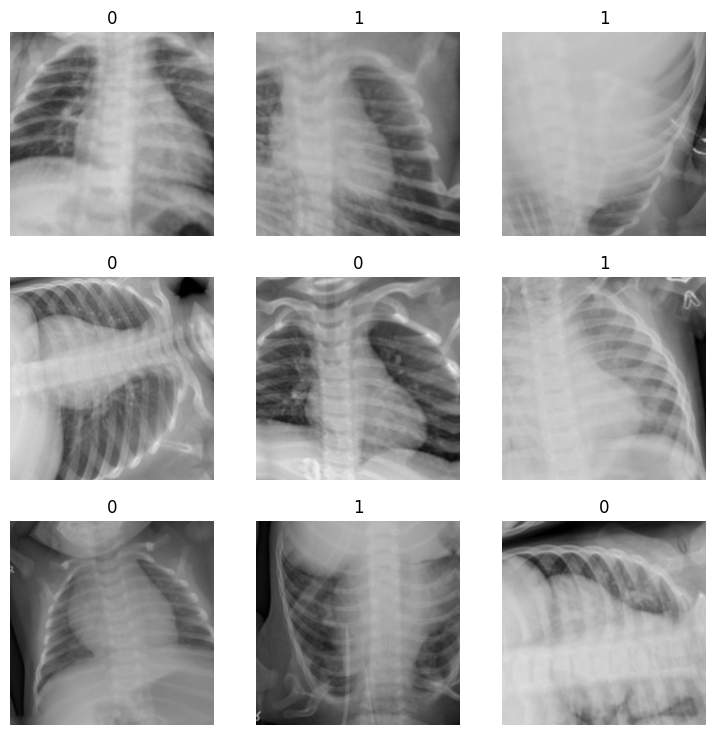

In [14]:
db_nue = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.15,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256,flip_vert=True,max_rotate=15),Normalize.from_stats(*imagenet_stats)])

dls_nue = db_nue.dataloaders(trainPath, bs=20)
dls_nue.show_batch()

In [15]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=10),
    SaveModelCallback(fname='modelResnet34ChestXRay')
]
learn = vision_learner(dls,resnet34,metrics=[accuracy, Precision(), Recall()],cbs=callbacks).to_fp16()

SuggestedLRs(valley=0.0020892962347716093)

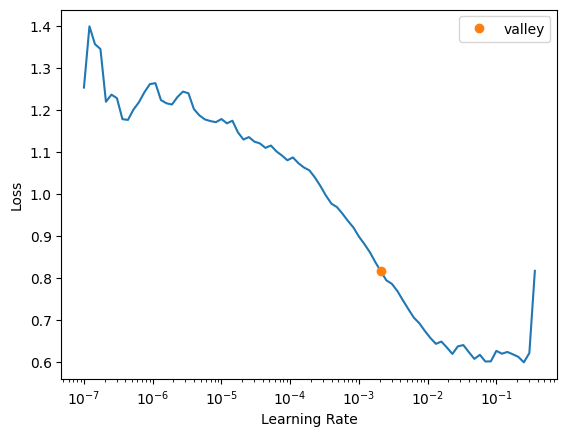

In [16]:
l_r = learn.lr_find()
l_r

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.149506,2.293286,0.333333,0.000000,0.000000,00:01


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 2.293285608291626.


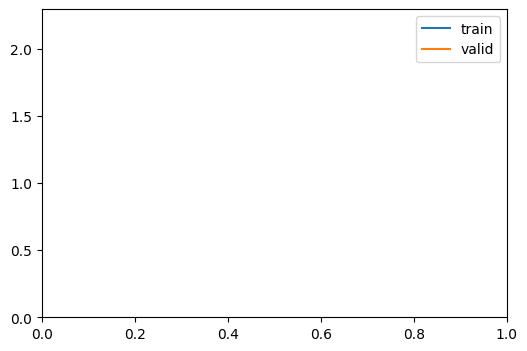

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.090787,2.007409,0.333333,0.000000,0.000000,00:01
1,1.092622,1.944988,0.333333,0.000000,0.000000,00:01
2,0.925148,1.842742,0.333333,0.000000,0.000000,00:00
3,0.871067,2.323898,0.333333,0.000000,0.000000,00:01
4,0.861269,2.068526,0.333333,0.000000,0.000000,00:00
5,0.856261,2.320137,0.333333,0.000000,0.000000,00:01
6,0.891412,2.541588,0.333333,0.000000,0.000000,00:01
7,0.839937,2.434078,0.333333,0.000000,0.000000,00:01
8,0.829377,2.302314,0.500000,1.000000,0.250000,00:01
9,0.779671,2.224062,0.500000,1.000000,0.250000,00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 2.0074093341827393.


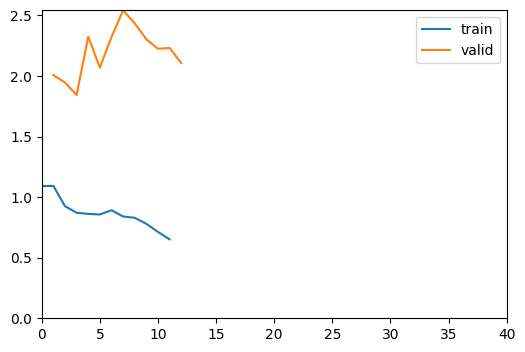

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with valid_loss value: 1.9449878931045532.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with valid_loss value: 1.8427419662475586.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/li

No improvement since epoch 2: early stopping


In [17]:
learn.fine_tune(40,base_lr=l_r.valley)

In [18]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=[*aug_transforms(size=128,min_scale=0.75),Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=128)
learn.dls = dlsTest
learn.validate()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


IndexError: Exception occured in `SaveModelCallback` when calling event `after_epoch`:
	list index out of range

## Pseudo-labeling iterativo (0.5 puntos)

Itera el proceso anterior mientras que no queden imágenes sin anotar o se alcance un número de iteraciones fijado por ti.

## Data-distillation (1 punto)

El ejercicio es similar al explicado para pseudo-labeling pero en este caso la clase de las imágenes sin anotar se debe obtener aplicando *test-time augmentation* (recuerda que FastAI ofrece la función `tta`).

## Model-distillation (1 punto)

El ejercicio es similar al explicado para pseudo-labeling pero en este caso la clase de las imágenes sin anotar se debe obtener aplicando un ensemble de modelos (conviene que entrenes modelos de distintas clases, es decir, no solo usar modelos de la familia resnet; y que el número de modelos sea impar). Para calcular el nivel de confianza puedes usar la media de los niveles de confianza de cada modelo. Deberás comprobar la mejora en cada uno de los modelos entrenados inicialmente.

## Model-data distillation (1 puntos)

En este ejercicio debes combinar tta con ensemble de modelos para obtener las predicciones de las imágenes sin anotar.

## Label propagation (1.5 puntos)

En este ejercicio deberás aplicar la técnica de label-propagation implementada en el paquete [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) para anotar las imágenes sin anotar. Para ello debes realizar los siguientes pasos:
1. Entrena un modelo con el dataset original usando lo visto en la práctica 1.
2. Para cada una de las imágenes extrae las características generadas en la última capa de la red. Para ello sigue los siguientes pasos:
    * Crea un extractor de características usando el siguiente comando ``feature_extractor = nn.Sequential(*list(learn.model.children())[:-1], Flatten())`` (esto elimina la última capa del modelo y añade una capa de aplanado).
    * Para extraer las características usa el comando ``featTensor = feature_extractor(learn.dls.test_dl([img]).one_batch()[0])``.
    * Para convertir las features generadas a un array de numpy usa el comando ``featTensor[0].cpu().detach().numpy()``.
3. Aplica la técnica de label propagation ([tutorial](https://machinelearningmastery.com/semi-supervised-learning-with-label-propagation/)) para etiquetar las imágenes sin anotar. Notar que la dimensión de los vectores generados puede ser bastante alta, por lo que es conveniente que apliques técnicas de reducción de la dimensionalidad.
4. Entrena un nuevo modelo con la combinación del dataset original y las nuevas imágenes anotadas obtenidas mediante label propagation.

Al finalizar, recuerda guardar los cambios en GitHub utilizando la opción Archivo -> Guardar una copia en GitHub.
